# ICESat-2 sea ice freeboards (ATL10) and deriving sea ice thickness

Information obtained primarily from the ATL07/10 Algorithm Theoretical Basis Document (ATBD, Kwok et al., 2019) and the NSIDC product description page: https://nsidc.org/data/atl07.   

Check out the known issues document for information about the current release/things to look out for: https://nsidc.org/sites/nsidc.org/files/technical-references/ATL0710-KnownIssues.pdf

* Notebook author: Alek Petty and Ellen Buckley  
* Description: Notebook describing the ICESat-2 ATL10 product (briefly) and some tips for deriving sea ice thickness using ancillary snow depth/density estimates.
* Input requirements: Demo ATL10 data file, NESOSIM snow depths.
* Date: June 2020
* More info: See the ATL07/ATL10 Algorithm Theoretical Basis Document (ATBD): https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL07_ATL10_ATBD_rel003.pdf    and the known issues document: https://nsidc.org/sites/nsidc.org/files/technical-references/ICESat2_ATL07-ATL10_Known_Issues_v002%2811-25-2019%29.pdf

**Please note that this notebook will not run in Binder without first uploading the required input data files.**

## Notebook objectives
* General understanding of the difference between ATL07 and ATL10
* Reading in, plotting and basic analysis of ATL10 data.
* How you too can calculate sea ice thickness from freeboard!



## ATL10 Background

ATL10 is a pretty simple product, with most of the hard work done in ATL03/07. ATL10 essentially returns the freeboard of the height segments calculated in ATL07 - the difference in height between the ice and sea surface. A local sea surface height is calculated in 10 km along-track sections using all relevant sea surface heights (ssh_flag) in each beam. 

A lot of the important variables in ATL07 have been passed through to ATL10 making this a useful high-level data product of interest to the community.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
import cartopy.crs as ccrs
import h5py
import scipy
from astropy.time import Time
import utils as ut
import readers as rd


In [2]:
#Magic function to enable interactive plotting in Jupyter notebook
%matplotlib inline

#### Import Data

As in the ATL07 Notebook, you can either get the data for this tutorial from the tutorial-data/sea-ice/ folder (at the hackweek) or download from NSIDC if you are running this on your local machine

In [3]:
data_loc='./data/' # update to where you downloaded the data
fname='ATL10-01_20181115003141_07240101_003_03.h5' # may have to change version number
fileT= data_loc+fname

In [4]:
# Here we use a function to pick out the relevant data in ATL10 and return a dataframe (in the ATL07 notebook this was done in-line instead)

def getATL10data(fileT, beam='gt1r', minFreeboard=0, maxFreeboard=10):
    """ Pandas/numpy ATL10 reader
    Written by Alek Petty, June 2018 (alek.a.petty@nasa.gov)

	I've picked out the variables from ATL10 I think are of most interest to sea ice users, 
    but by no means is this an exhastive list. 
    See the xarray or dictionary readers to load in the more complete ATL10 dataset
    or explore the hdf5 files themselves (I like using the app Panpoly for this) to see what else you might want
    
	Args:
		fileT (str): File path of the ATL10 dataset
		beamStr (str): ICESat-2 beam (the number is the pair, r=strong, l=weak)
        maxFreeboard (float): maximum freeboard (meters)

	returns:
        pandas dataframe
        
    Versions:
        v1: June 2018
        v2: June 2020 - cleaned things up, changed the time function slightly to be consistent with Ellen's ATL07 reader.

	"""

    print('ATL10 file:', fileT)
    
    f1 = h5py.File(fileT, 'r')
    
    # Freeboards
    freeboard=f1[beam]['freeboard_beam_segment']['beam_freeboard']['beam_fb_height'][:]
    ssh_flag=f1[beam]['freeboard_beam_segment']['height_segments']['height_segment_ssh_flag'][:]
    
    # ATL07 heights
    height=f1[beam]['freeboard_beam_segment']['height_segments']['height_segment_height'][:]
    
    # Freeboard confidence and freeboard quality flag
    freeboard_confidence=f1[beam]['freeboard_beam_segment']['beam_freeboard']['beam_fb_confidence'][:]
    freeboard_quality=f1[beam]['freeboard_beam_segment']['beam_freeboard']['beam_fb_quality_flag'][:]
    
    # Delta time in gps seconds
    delta_time = f1[beam]['freeboard_beam_segment']['beam_freeboard']['delta_time'][:]
    
    # Along track distance from the equator
    # Convert this to kilometers from the start of the granule
    seg_x = f1[beam]['freeboard_beam_segment']['beam_freeboard']['seg_dist_x'][:]
    seg_x=(seg_x-seg_x[0])*0.001
    
    # Height segment ID (10 km segments)
    height_segment_id=f1[beam]['freeboard_beam_segment']['beam_freeboard']['height_segment_id'][:]
    
    lons=f1[beam]['freeboard_beam_segment']['beam_freeboard']['longitude'][:]
    lats=f1[beam]['freeboard_beam_segment']['beam_freeboard']['latitude'][:]
    
    # Time since the start of the granule
    deltaTimeRel=delta_time-delta_time[0]
    
    # #Add this value to delta time parameters to compute full gps_seconds
    atlas_epoch=f1['/ancillary_data/atlas_sdp_gps_epoch'][0] 
    gps_seconds = atlas_epoch + delta_time

    ## Use astropy to convert GPS time to UTC time
    tiso=Time(gps_seconds,format='gps').utc.datetime

    dF = pd.DataFrame({'freeboard':freeboard, 'freeboard_quality':freeboard_quality, 'height':height, 'ssh_flag':ssh_flag, 'lon':lons, 'lat':lats, 'delta_time':delta_time,'deltaTimeRel':deltaTimeRel, 
                     'height_segment_id':height_segment_id,'datetime': tiso, 'seg_x':seg_x})
    
    dF = dF[(dF['freeboard']>=minFreeboard)]
    dF = dF[(dF['freeboard']<=maxFreeboard)]
    
    # Also filter based on the confidence and/or quality flag?
    
    # Reset row indexing
    dF=dF.reset_index(drop=True)

    return dF

#### Read in the data using the pandas reader above. Copied from the readers.py script.

* Take a look at the top few rows (change the number in head to increase this..)    
* Play around with the max/min freeboards. Note how without this we get some very large NaNs at the start of the granule. You could change the reader and set these to np.nan instead of just removing those rows if you want.
* Any other variables you might want to use?

In [5]:
beamStr='gt1r'
dF10 = getATL10data(fileT, beam=beamStr)
dF10.head()

ATL10 file: ./data/ATL10-01_20181115003141_07240101_003_03.h5


,freeboard,freeboard_quality,height,ssh_flag,lon,lat,delta_time,deltaTimeRel,height_segment_id,datetime,seg_x
0,0.136071,1,0.088112,0,-168.496847,73.448986,2.747825e+07,214.786496,272,2018-11-15 00:50:53.510453,1525.396541
1,0.124071,1,0.076111,0,-168.496867,73.449025,2.747825e+07,214.787120,273,2018-11-15 00:50:53.511076,1525.400983
2,0.116132,1,0.068173,0,-168.496879,73.449050,2.747825e+07,214.787513,274,2018-11-15 00:50:53.511470,1525.403786
3,0.099979,1,0.052020,0,-168.496895,73.449082,2.747825e+07,214.788020,275,2018-11-15 00:50:53.511976,1525.407397
4,0.084768,1,0.036809,0,-168.496915,73.449122,2.747825e+07,214.788648,276,2018-11-15 00:50:53.512605,1525.411871


#### Map the data for visual inspection using Cartopy 
*NB (Basemap is often used for mapping but is not being officially supported by the community anymore) so we've tried to focus on Cartopy here*

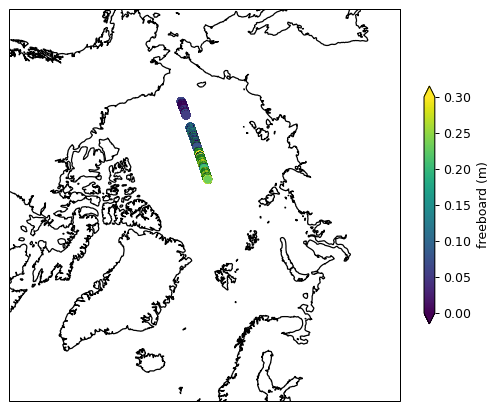

In [6]:
var='freeboard'
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
# ccrs.PlateCarree
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.scatter(dF10['lon'], dF10['lat'],c=dF10[var], cmap='viridis', vmin=0, vmax=0.3, transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label=var+' (m)', shrink=0.5, extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

#### Let's try and calculate sea ice thickness!

* First we apply Warren snow depth and density data to each row (segment) of data.
* Below function adds data from the Warren quadratc functional fits for the given time/location of each freeboard point


In [7]:
# Add this to the dataframe
dF10=ut.getWarrenData(dF10, 'snow_depth_W99', outDensityVar='snow_density_W99')
dF10.head()

,freeboard,freeboard_quality,height,ssh_flag,lon,lat,delta_time,deltaTimeRel,height_segment_id,datetime,seg_x,snow_depth_W99,snow_density_W99
0,0.136071,1,0.088112,0,-168.496847,73.448986,2.747825e+07,214.786496,272,2018-11-15 00:50:53.510453,1525.396541,0.180751,286.270514
1,0.124071,1,0.076111,0,-168.496867,73.449025,2.747825e+07,214.787120,273,2018-11-15 00:50:53.511076,1525.400983,0.180752,286.270481
2,0.116132,1,0.068173,0,-168.496879,73.449050,2.747825e+07,214.787513,274,2018-11-15 00:50:53.511470,1525.403786,0.180752,286.270460
3,0.099979,1,0.052020,0,-168.496895,73.449082,2.747825e+07,214.788020,275,2018-11-15 00:50:53.511976,1525.407397,0.180752,286.270433
4,0.084768,1,0.036809,0,-168.496915,73.449122,2.747825e+07,214.788648,276,2018-11-15 00:50:53.512605,1525.411871,0.180753,286.270400


We then convert the freeboard to thickness using the Warren snow depth/density. The function this calls assumes the sea ice is in hydrostatic equlibirum. Why/when might this be invalid?

In [8]:
dF10=ut.getSnowandConverttoThickness(dF10, snowDepthVar='snow_depth_W99', 
                                 snowDensityVar='snow_density_W99',
                                 outVar='ice_thickness_W99')
dF10.head()

,freeboard,freeboard_quality,height,ssh_flag,lon,lat,delta_time,deltaTimeRel,height_segment_id,datetime,seg_x,snow_depth_W99,snow_density_W99,ice_thickness_W99
0,0.136071,1,0.088112,0,-168.496847,73.448986,2.747825e+07,214.786496,272,2018-11-15 00:50:53.510453,1525.396541,0.180751,286.270514,0.393466
1,0.124071,1,0.076111,0,-168.496867,73.449025,2.747825e+07,214.787120,273,2018-11-15 00:50:53.511076,1525.400983,0.180752,286.270481,0.358765
2,0.116132,1,0.068173,0,-168.496879,73.449050,2.747825e+07,214.787513,274,2018-11-15 00:50:53.511470,1525.403786,0.180752,286.270460,0.335810
3,0.099979,1,0.052020,0,-168.496895,73.449082,2.747825e+07,214.788020,275,2018-11-15 00:50:53.511976,1525.407397,0.180752,286.270433,0.289101
4,0.084768,1,0.036809,0,-168.496915,73.449122,2.747825e+07,214.788648,276,2018-11-15 00:50:53.512605,1525.411871,0.180753,286.270400,0.245117


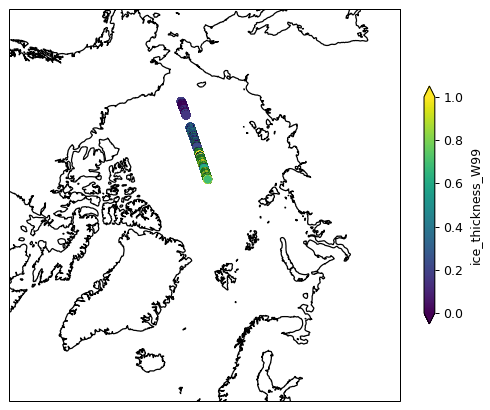

In [9]:
# Map the data for visual inspection using Cartopy
var='ice_thickness_W99'
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.scatter(dF10['lon'], dF10['lat'],c=dF10[var], cmap='viridis', vmin=0, vmax=1, transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label=var, shrink=0.5, extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

Now do this for the NESOSIM snow depths (https://github.com/akpetty/NESOSIM)

In [12]:
# Apply the NESOSIM snow depth and density
dF10=ut.getNESOSIM(dF10, './Data/NESOSIM_IS2_100kmv56-15082018-30042019.nc', outSnowVar='snow_depth_N', outDensityVar='snow_density_N')
# Calculate thickness
dF10=ut.getSnowandConverttoThickness(dF10, snowDepthVar='snow_depth_N', 
                                 snowDensityVar='snow_density_N',
                                 outVar='ice_thickness_N')
dF10.head()

Check dates (should be within a day): 20181115 20181115


OSError: [Errno -101] NetCDF: HDF error: b'/home/jovyan/2020_ICESat-2_Hackweek_Tutorials/10.Sea_Ice_Applications/Data/NESOSIM_IS2_100kmv56-15082018-30042019.nc'

In [ ]:
# cut to middle part of the granule
minlat=85.4
maxlat=86
dF10r=dF10[(dF10.lat>minlat)&(dF10.lat<maxlat)]
dF10r.head()

In [ ]:
# Map the data for visual inspection using Cartopy
var='ice_thickness_N'
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.scatter(dF10r['lon'], dF10r['lat'],c=dF10r[var], cmap='viridis', vmin=0, vmax=1, transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label=var, shrink=0.5, extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

In [ ]:
fig,ax=plt.subplots(4,1,figsize=(12,12))

ax[0].scatter(dF10r['seg_x'],dF10r['height'],c=dF10r['height'], s=2, cmap='hot')
ax[0].set_ylim(0,2)
ax[0].set_ylabel('Heights (m)',fontsize=12)
ax[0].set_xticklabels([])

ax[1].scatter(dF10r['seg_x'],dF10r['freeboard'], c=dF10r['freeboard'], s=2, cmap='hot')
ax[1].set_ylabel('Freeboard (m)',fontsize=12)
ax[1].set_ylim(0,2)
ax[1].set_xticklabels([])
mean=str(np.round(np.mean(dF10r['freeboard']), 2))
ax[1].annotate('Mean: '+mean, xy=(0.01, 0.9),xycoords='axes fraction', fontsize=12)

ax[2].plot(dF10r['seg_x'],dF10r['ice_thickness_W99'], c='r', label='Warren99', alpha=0.2)
ax[2].plot(dF10r['seg_x'],dF10r['ice_thickness_N'], c='k', label='NESOSIM', alpha=0.2)
ax[2].legend()
ax[2].set_ylabel('Sea ice thickness (m)',fontsize=12)
ax[2].set_ylim(0,15)
ax[2].set_xticklabels([])
meanW99=str(np.round(np.mean(dF10r['ice_thickness_W99']), 2))
ax[2].annotate('Mean W99: '+meanW99, xy=(0.01, 0.9),xycoords='axes fraction', fontsize=12)
meanN=str(np.round(np.mean(dF10r['ice_thickness_N']), 2))
ax[2].annotate('Mean N: '+meanN, xy=(0.01, 0.8),xycoords='axes fraction', fontsize=12)


ax[3].scatter(dF10r['seg_x'],dF10r['ssh_flag'],c='k',s=2)
ax[3].grid()
ax[3].set_ylim(-1,2)
ax[3].set_yticks(np.arange(0,2,1))
ax[3].set_yticklabels(['sea ice', 'sea surface'])
ax[3].set_ylabel('ATL10 \nssh flag',fontsize=12)
ax[3].set_xlabel('Along track distance (km)',fontsize=12)

for a in np.arange(0,4):
    ax[a].set_xlim(dF10r['seg_x'].iloc[0],dF10r['seg_x'].iloc[-1])
    width=1
    for index, row in dF10r.iterrows():
        x0 = row['seg_x'] 
        if row['ssh_flag'] > 0.5:
            ax[a].axvline(x0,c='y',alpha=.3, linewidth=width)


## Extra stuff

Another key (and possibly overlooked) variable when using ATL10 is the quality flag. This is derived in ATL07 and describes the 'quality' of the functional (Gaussian) fit of the 150 ATL03 photons. Higher numbers (it goes from 1 to 5 with ) indicate a worse fit. In the r002 data only heights with a quality flag less than or equal to 3 are used, however this has been increased to 4 in r003.

Let's take a look at this quality flag..

In [ ]:
# Note now that we color the scatter based on the quality flag
# The second panel then shows the quality flag itself on the y-axis. 
# Here we are using the entire granule (as the regional subset quality flags are all 1!)

fig,ax=plt.subplots(2,1,figsize=(12,8))

ax[0].scatter(dF10['seg_x'],dF10['freeboard'],c=dF10['freeboard_quality'], vmin=0, vmax=3, s=2, cmap='viridis')
ax[0].set_ylim(-0.1,2)
ax[0].set_ylabel('Freeboard (m)',fontsize=12)
mean=str(np.round(np.mean(dF10['freeboard']), 2))
ax[0].annotate('Mean: '+mean, xy=(0.01, 0.9),xycoords='axes fraction', fontsize=12)

ax[1].scatter(dF10['seg_x'],dF10['freeboard_quality'], c=dF10['freeboard_quality'], s=2, cmap='viridis')
ax[1].set_ylabel('Quality flag',fontsize=12)
ax[1].set_ylim(0,4)
ax[1].set_xlabel('Along track distance (km)',fontsize=12)


In [ ]:
# Now let's impose a stricter quality_flag mask on the data and assign this to a new dataframe
# Quality
dF10_q = dF10.copy()
dF10_q[dF10['freeboard_quality'] > 1] = np.nan
dF10_q.head()

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(12,8))

ax[0].scatter(dF10_q['seg_x'],dF10_q['freeboard'],c=dF10_q['freeboard_quality'], vmin=0, vmax=3, s=2, cmap='viridis')
ax[0].set_ylim(-0.1,2)
ax[0].set_ylabel('Freeboard (m)',fontsize=12)
mean=str(np.round(np.mean(dF10_q['freeboard']), 2))
ax[0].annotate('Mean: '+mean, xy=(0.01, 0.9),xycoords='axes fraction', fontsize=12)

ax[1].scatter(dF10_q['seg_x'],dF10_q['freeboard_quality'], c=dF10['freeboard_quality'], s=2, cmap='viridis')
ax[1].set_ylabel('Quality flag',fontsize=12)
ax[1].set_ylim(0,4)
ax[1].set_xlabel('Along track distance (km)',fontsize=12)

Well it didn't change the mean freeboard but it might be worth looking into the distribution of these high quality flag segments and understanding their possible cause!..